In [1]:
import tensorflow as tf
import librosa
import numpy as np
import os
import matplotlib.pyplot as plt
from keras import models,layers
from keras.models import Model

In [2]:
path="../Data"
d={}
SAMPLE_RATE=16000
CLASSES=2
N_MELS=128
X_train,X_test,X_val,Y_train,Y_test,Y_val=[],[],[],[],[],[]

In [3]:
for fol in os.listdir(path):
    print(fol)

testing
training
validation


In [4]:
#setting path to different subsets of data
train_path=os.path.join(path,'/Data/training').replace('\\','/')
test_path=os.path.join(path,'testing').replace("\\","/")
validation_path=os.path.join(path,'validation').replace("\\","/")

In [5]:
#converting audio file to tensor
def mel_spectrogram(file):
    audio,sample_rate=librosa.load(file)
    mel_audio=librosa.feature.melspectrogram(y=audio,sr=sample_rate)
    mel_spectrogram = librosa.power_to_db(np.abs(mel_audio)**2, ref=np.max)
    max_time_steps = 128
    if mel_spectrogram.shape[1] < max_time_steps:
        mel_spectrogram = np.pad(mel_spectrogram, ((0, 0), (0, max_time_steps - mel_spectrogram.shape[1])), mode='constant')
    else:
        mel_spectrogram = mel_spectrogram[:, :max_time_steps]
    return mel_spectrogram

In [28]:
def fit_data(path):
    X,Y=[],[]
    for dir in os.listdir(path):
        new_path=os.path.join(path,dir).replace('\\','/')
        for file in os.listdir(new_path):
            X.append(mel_spectrogram(os.path.join(new_path,file).replace("\\","/")))
            Y.append(0 if(dir)=="fake" else 1)
    return X,Y

In [ ]:
#Transforming audios to spectrograms
X_train,Y_train=fit_data(train_path)
X_test,Y_test=fit_data(test_path)
X_val,Y_val=fit_data(validation_path)

In [8]:
#Converting tensor list to numpy array
X_train=np.array(X_train)
Y_train=np.array(Y_train)
X_test=np.array(X_test)
Y_test=np.array(Y_test)
X_val=np.array(X_val)
Y_val=np.array(Y_val)

In [ ]:
np.save("../Transformed Data/X_train.npy",X_train)
np.save("../Transformed Data/Y_train.npy",Y_train)
np.save("../Transformed Data/X_test.npy",X_test)
np.save("../Transformed Data/Y_test.npy",Y_test)
np.save("../Transformed Data/X_val.npy",X_val)
np.save("../Transformed Data/Y_val.npy",Y_val)

In [9]:
Y_train = tf.keras.utils.to_categorical(Y_train, CLASSES)
Y_test = tf.keras.utils.to_categorical(Y_test, CLASSES)
Y_val = tf.keras.utils.to_categorical(Y_val, CLASSES)

In [10]:
#creating neural network model
input = tf.keras.Input(shape=(128,128,1))

x = layers.Conv2D(64,(4,4),activation='relu')(input)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((3,3))(x)
x = layers.Conv2D(48,(4,4),activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Conv2D(32,(3,3),activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x=layers.Flatten()(x)
output = layers.Dense(CLASSES, activation='softmax')(x)

In [ ]:
model = Model(inputs=input,outputs=output)

In [ ]:
model.summary()

In [ ]:
model.fit(X_train, Y_train, batch_size=64, epochs=49, validation_data=(X_val, Y_val))

In [ ]:
#saving model
model.save(os.path.join(path,"/Models/2d_model_64_nor_sgd.h5"))

In [8]:
X_train=np.load("../Transformed Data/X_train.npy")
Y_train=np.load("../Transformed Data/Y_train.npy")
X_test=np.load("../Transformed Data/X_test.npy")
Y_test=np.load("../Transformed Data/Y_test.npy")
X_val=np.load("../Transformed Data/X_val.npy")
Y_val=np.load("../Transformed Data/Y_val.npy")

In [9]:
#loading model
model=tf.keras.models.load_model("../Models/2d_model_32_nor_nadam.h5")
print(model.summary())



Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      1088      
                                                                 
 batch_normalization_3 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 41, 41, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 38, 38, 48)        49200     
                                                                 
 batch_normalization_4 (Bat  (None, 38, 38, 48)        19

In [12]:
#model evaluation
Y_test= tf.keras.utils.to_categorical(Y_test, CLASSES)
model.evaluate(X_test,Y_test)


145/145 [==============================] - 17s 111ms/step - loss: 0.1253 - accuracy: 0.9657


[0.1252620369195938, 0.9657105803489685]

In [16]:
#Predicting output of a single audio file
classes=['fake','real']
audio_file=mel_spectrogram(os.path.join(test_path,"fake/file100.wav_16k.wav_norm.wav_mono.wav_silence.wav"))
prediction=model.predict(tf.expand_dims(audio_file, 0))
predicted_class = classes[np.argmax(prediction)]
confidence = np.max(prediction)
print("Prediction:",predicted_class)
print("Confidence:",confidence) 

1/1 [==============================] - 0s 176ms/step
Prediction: fake
Confidence: 1.0


In [ ]:
#Visualization

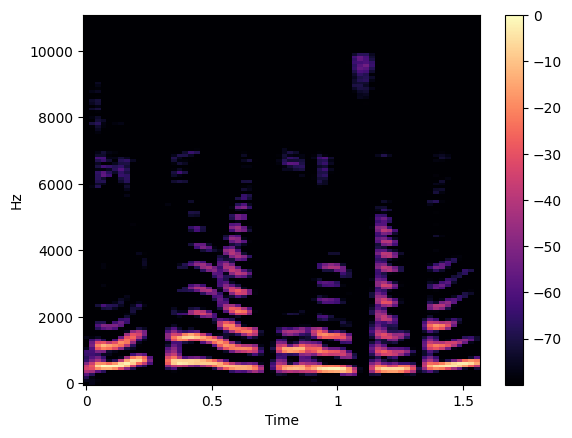

In [19]:
def display_melspectrogram(file):
    audio,sample_rate=librosa.load(file)
    mel_audio=librosa.feature.melspectrogram(y=audio,sr=sample_rate)
    mel_spectrogram = librosa.power_to_db(np.abs(mel_audio)**2, ref=np.max)
    librosa.display.specshow(mel_spectrogram,sr=sample_rate,x_axis='time',y_axis='linear')
    plt.colorbar()

for file in os.listdir(os.path.join(test_path,"fake")):
      display_melspectrogram(os.path.join(test_path,"fake",file))
      break

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)

In [13]:
from sklearn.metrics import confusion_matrix

predictions=model.predict(X_test)
predicted_labels=np.argmax(predictions,axis=1)
true_labels=np.argmax(Y_test,axis=1)
cm=confusion_matrix(true_labels,predicted_labels)
print("Confusion Matrix:",cm,sep='\n')


145/145 [==============================] - 17s 115ms/step
Confusion Matrix:
[[2279   91]
 [  68 2199]]


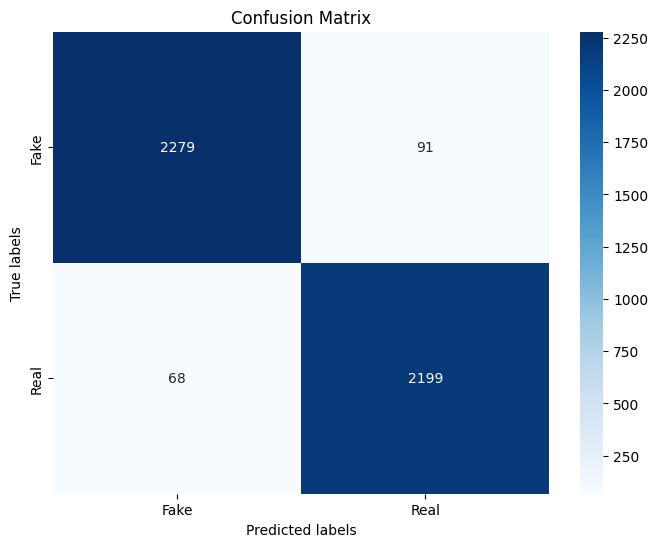

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = ["Fake","Real"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [23]:
def plot_bar_graph(category,subcategory,data,n):
    unique_categories = list(set(category))
    unique_categories.sort()  
    unique_subcategories = list(set(subcategory))

    bar_width = 0.35
    space = 0.2

    color_map = {'Accuracy': 'green', 'Loss': 'red'}
    fig, ax = plt.subplots(figsize=(10, 6))

    bars=[]
    for i, cat in enumerate(unique_categories):
        bars = []
        cat_data = [val for j, val in enumerate(subcategory) if cat == category[j]]
        cat_value = [data[j] for j, val in enumerate(subcategory) if cat == category[j]]
        x = [i + j * (bar_width + space) for j in range(len(cat_data))]
        b = ax.bar(x, cat_value, bar_width, label=cat, color=[color_map[val] for val in cat_data])
        bars.append(b[0])
        bars.append(b[1])

    ax.set_xlabel('Category')
    ax.set_ylabel('Value')
    ax.set_title('Comparison of models trained with Batch Size:'+str(n))

    plt.xticks([i + (bar_width + space) / 2 for i in range(len(unique_categories))], unique_categories, rotation=45, ha='right')
    ax.legend(bars, unique_subcategories)
    plt.tight_layout()
    plt.show()

145/145 [==============================] - 16s 109ms/step - loss: 0.1197 - accuracy: 0.9681


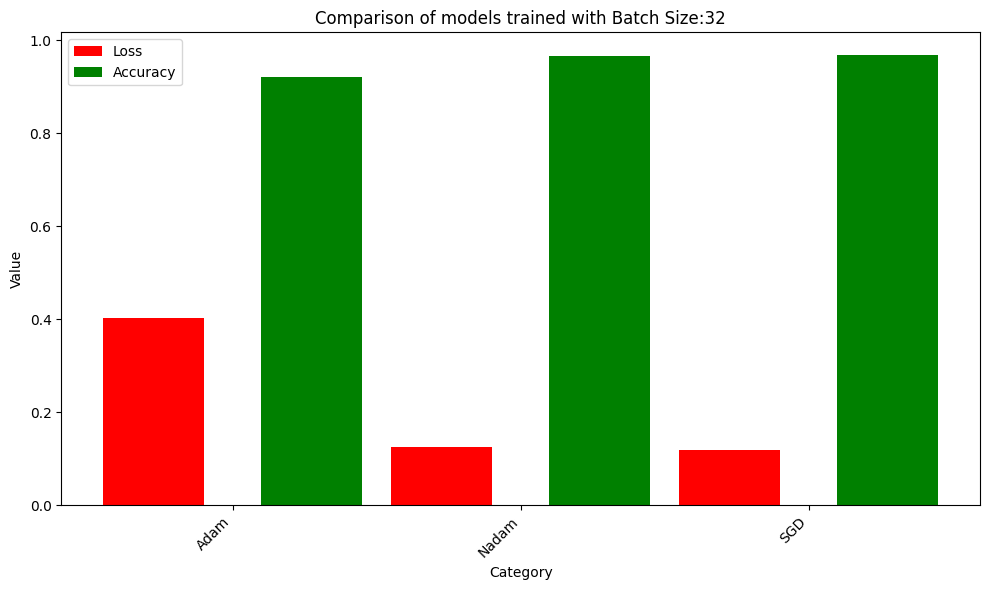

In [25]:
#for 32 batch size
category=["Adam","Adam","Nadam","Nadam","SGD","SGD"]
subcategory=["Loss", "Accuracy","Loss","Accuracy","Loss","Accuracy"]
model=tf.keras.models.load_model("../Models/2d_model_32_nor_adam.h5")
adam_32=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_32_nor_nadam.h5")
nadam_32=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_32_nor_sgd.h5")
sgd_32=model.evaluate(X_test,Y_test)
data=[adam_32[0],adam_32[1],nadam_32[0],nadam_32[1],sgd_32[0],sgd_32[1]]
plot_bar_graph(category,subcategory,data,32)

145/145 [==============================] - 16s 109ms/step - loss: 0.9821 - accuracy: 0.7979


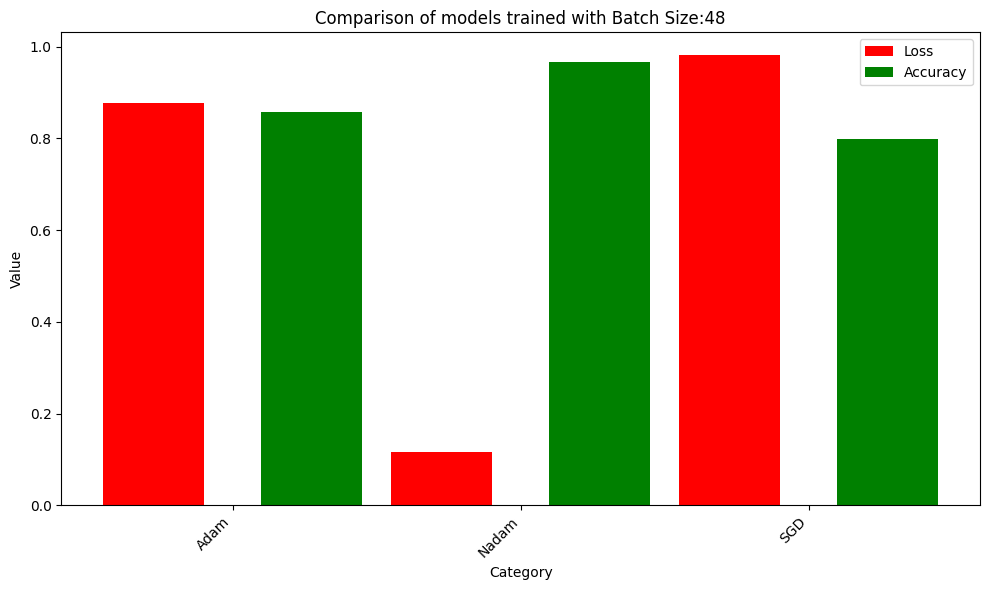

In [26]:
#for 48 batch size
category=["Adam","Adam","Nadam","Nadam","SGD","SGD"]
subcategory=["Loss", "Accuracy","Loss","Accuracy","Loss","Accuracy"]
model=tf.keras.models.load_model("../Models/2d_model_48_nor_adam.h5")
adam_48=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_48_nor_nadam.h5")
nadam_48=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_48_nor_sgd.h5")
sgd_48=model.evaluate(X_test,Y_test)
data=[adam_48[0],adam_48[1],nadam_48[0],nadam_48[1],sgd_48[0],sgd_48[1]]
plot_bar_graph(category,subcategory,data,48)

145/145 [==============================] - 17s 116ms/step - loss: 0.2874 - accuracy: 0.9204


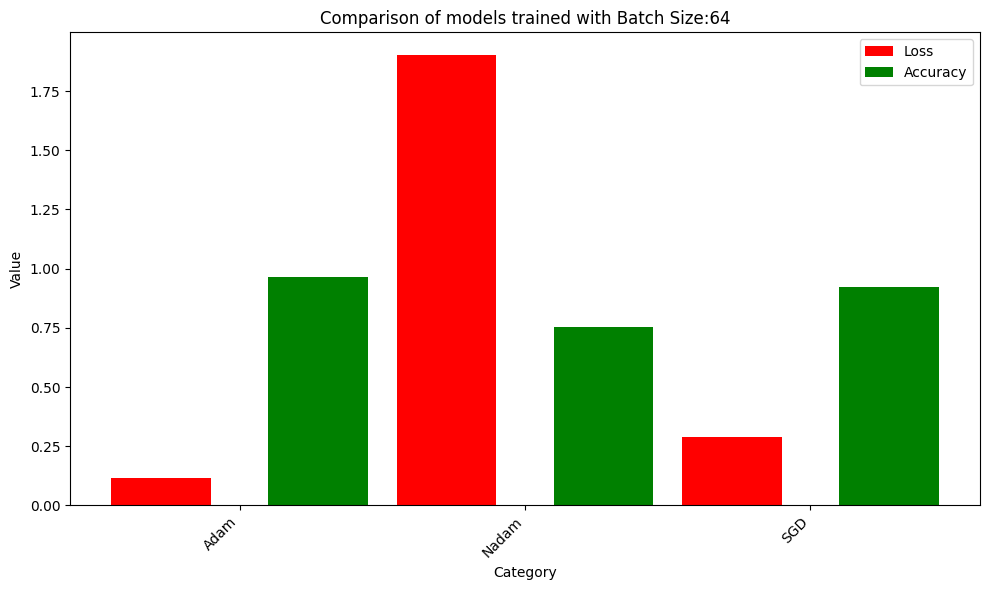

In [27]:
#for 64 batch size
category=["Adam","Adam","Nadam","Nadam","SGD","SGD"]
subcategory=["Loss", "Accuracy","Loss","Accuracy","Loss","Accuracy"]
model=tf.keras.models.load_model("../Models/2d_model_64_nor_adam.h5")
adam_64=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_64_nor_nadam.h5")
nadam_64=model.evaluate(X_test,Y_test)
model=tf.keras.models.load_model("../Models/2d_model_64_nor_sgd.h5")
sgd_64=model.evaluate(X_test,Y_test)
data=[adam_64[0],adam_64[1],nadam_64[0],nadam_64[1],sgd_64[0],sgd_64[1]]
plot_bar_graph(category,subcategory,data,64)